**Author**: [Alex FitzGerald](https://www.linkedin.com/in/alex-fitzgerald-0734076a/)

![windjammer header](visuals/windjammer_logo.jpg)

## Overview
This project creates a user-friendly customer lifetime value (CLV) prediction engine able to take in transaction data and return important CLV predictions with a high degree of accuracy for a merchant's entire customer base and individual customers over a selected period of time in the future. The data processing and modeling techniques were validated on a publicly available e-commerce data set from Olist but the app is flexible enough to re-process and model unstructured transaction data from any non-contractual business with continuous purchasing behavior (ex. grocery purchases, e-commerce, movie rentals).

## Business Problem
How much are your customers worth? CLV is a north star metric for marketers and key to many business analyses; sales/marketing activity ROI, sales forecasts, company valuation, churn mitigation tactics, and customer persona analysis. 

Olist, the largest e-commerce department store in Brazil, wants to help the small business merchants who sell goods through their marketplace understand their CLV. Olist makes their money taking a commission on orders placed on their marketplace. They want to help their merchants sell more products and retain those merchants on their marketplace by providing top-notch business analytics.

Olist has decided to create a user friendly app to help their merchants better understand the customers who buy their products through the Olist marketplace. Empowering their merchants with CLV analysis will help merchants improve their strategy and increase sales and commissions through Olist. The addition of a customer insight tool will also improve the retention of merchants on the Olist network. 

To accomplish this project, Olist has hired Windjammer Consulting, a data-science consulting firm.

To test out the app for accuracy, Olist has provided a full transaction data set of purchases from all vendors and asked Windjammer Consulting to return CLV predictions with minimal error (RMSE).
If the model passes muster, they want Windjammer Consulting to create an application that allows merchants to upload their own data and retrieve predictions.

## Modeling


In [1]:
#Inital imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
from lifetimes.plotting import plot_period_transactions, plot_calibration_purchases_vs_holdout_purchases
from lifetimes import BetaGeoFitter, GammaGammaFitter
from datetime import timedelta
from datetime import datetime
from dateutil import parser
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
!ls data

OnlineRetail_2yrs.csv             customer_data_base.zip
brave_transactions.csv            lifetimes_object_df.csv
business_context.jpg              lifetimes_object_df_uncleaned.csv


In [3]:
#Load in our pre-prepared dataframes
lifetimes_object_df = pd.read_csv("data/lifetimes_object_df.csv")

### Preparation and evaluation functions

In [4]:
#Load in our data wrangler
from lifetimes.utils import summary_data_from_transaction_data
#Import holdout 
from lifetimes.utils import calibration_and_holdout_data

In [5]:
#class to return a calibration and holdout df
class df_ch():
    def __init__(self, eval_period=None,transaction_df=None,purchase_timestamp_col=None,customer_id_col=None,datetime_col=None,monetary_value_col=None):
        #initialized attributes
        self.eval_period = eval_period
        self.transaction_df = transaction_df
        self.purchase_timestamp_col=purchase_timestamp_col
        self.customer_id_col=customer_id_col
        self.datetime_col=datetime_col
        self.monetary_value_col=monetary_value_col
        #save off more attributes
        self.min_obs_date = parser.parse(transaction_df[purchase_timestamp_col].min())
        self.max_obs_date = parser.parse(transaction_df[purchase_timestamp_col].max())
        self.max_calib_date = self.max_obs_date - timedelta(days=eval_period)  
        self.calib_range_days = (self.max_calib_date - self.min_obs_date).days
    def df_ch_getdf(self):
        df = calibration_and_holdout_data(
        transactions = self.transaction_df, 
        customer_id_col=self.customer_id_col,
        datetime_col=self.datetime_col,
        monetary_value_col=self.monetary_value_col,
        calibration_period_end = self.max_calib_date, 
        observation_period_end = self.max_obs_date, 
        freq = "D")
        return df
        

In [6]:
#function to return a df of real and predicted transacitons in eval period
def bgf_real_v_pred_df(ch,bgf):
    rfm_cal_holdout = pd.DataFrame()
    ch_df = ch.df_ch_getdf()
    rfm_cal_holdout["n_transactions_cal_real"]  = ch_df["frequency_cal"] + 1 #Total calibration days with purchases = calibration frequency + 1
    rfm_cal_holdout["n_transactions_holdout_real"]  = ch_df["frequency_holdout"] #Total validation days with purchases = validation frequency
    # the predicted number of transactions
    rfm_cal_holdout["n_transactions_holdout_pred"] = bgf.predict(t=ch.eval_period, 
                                                    frequency=ch_df['frequency_cal'], 
                                                    recency=ch_df['recency_cal'], 
                                                    T=ch_df['T_cal'])
    return rfm_cal_holdout[["n_transactions_cal_real","n_transactions_holdout_real", "n_transactions_holdout_pred"]]

In [7]:
#function to capture RMSE for a BGF model
def bgf_rmse(ch,bgf):
    df_ch = ch.df_ch_getdf()
    df_ch["n_transactions_holdout_real"] = df_ch["frequency_holdout"]
    y_true = df_ch["n_transactions_holdout_real"]
    y_pred = bgf.predict(t=ch.eval_period, frequency=df_ch['frequency_cal'],
                         recency=df_ch['recency_cal'],
                         T=df_ch['T_cal'])

    return mean_squared_error(y_true,y_pred,squared=False)

In [8]:
#function to return predicted # transactions for given customer in evaluation period
def samp_cust_pred_trans(df_ch,sample_customer_id,eval_period):
    sample_customer = df_ch.loc[sample_customer_id]
    n_transactions_pred = bgf.predict(t=eval_period,
                                  frequency=sample_customer['frequency_cal'], 
                                  recency=sample_customer['recency_cal'], 
                                  T=sample_customer['T_cal'])
    return(n_transactions_pred)

In [9]:
#Dummy model function that predicts the same purchase rate in the observation period to continue through the eval period
def bgf_dummy_model(ch):
    df_ch = ch.df_ch_getdf()
    dummy_ch_df = pd.DataFrame()
    dummy_ch_df["purchases_per_period_cal"] = df_ch["frequency_cal"] + 1 #Total calibration days with purchases = calibration frequency + 1
    dummy_ch_df["purchases_per_period_cal"] = dummy_ch_df["purchases_per_period_cal"]/ch.calib_range_days #Purchase rate
    dummy_ch_df["dummy_pred_purchases_holdout"] = dummy_ch_df["purchases_per_period_cal"] * ch.eval_period #Predicting purchase rate to continue
    dummy_ch_df["dummy_pred_purchases_holdout"] = np.round(dummy_ch_df["dummy_pred_purchases_holdout"]) #Round to get an actual number of predictions
    dummy_ch_df["actual_purchases_holdout"] = df_ch["frequency_holdout"] #Total validation days with purchases = validation frequency
    return mean_squared_error(y_true=dummy_ch_df["dummy_pred_purchases_holdout"],y_pred=dummy_ch_df["actual_purchases_holdout"],squared=False)


In [10]:
#function to return a df of real and predicted transacitons in eval period for dummy model
def bgf_dummy_real_v_pred_df(ch):
    df_ch = ch.df_ch_getdf()
    dummy_ch_df = pd.DataFrame()
    dummy_ch_df["purchases_per_period_cal"] = df_ch["frequency_cal"] + 1 #Total calibration days with purchases = calibration frequency + 1
    dummy_ch_df["purchases_per_period_cal"] = dummy_ch_df["purchases_per_period_cal"]/ch.calib_range_days #Purchase rate
    dummy_ch_df["dummy_pred_purchases_holdout"] = dummy_ch_df["purchases_per_period_cal"] * ch.eval_period #Predicting purchase rate to continue
    dummy_ch_df["actual_purchases_holdout"] = df_ch["frequency_holdout"] #Total validation days with purchases = validation frequency
    return dummy_ch_df

### RFM data exploration 

In [11]:
#use Lifetimes utilitity function to transform our data into an RFM (recency, requency, monetary value) object
summary = summary_data_from_transaction_data(transactions=lifetimes_object_df,customer_id_col='customer_unique_id',
                                             datetime_col='order_purchase_timestamp',monetary_value_col='payment_value',observation_period_end='2018-10-17')
summary

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,160.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,163.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,586.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,370.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,337.0,0.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,496.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,311.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,617.0,0.0


In [12]:
#We have some significant co-linearity but this isn't a concern. We actually expect co-lineary which is why we are
#using a hierarchical modeling approach because we expect groups with common rfm scores to move togiether. 
#Importantly, we do not have co-linearity between T and monetary_value
summary.corr()

,frequency,recency,T,monetary_value
frequency,1.000000,0.702598,0.069469,0.614334
recency,0.702598,1.000000,0.101774,0.472158
T,0.069469,0.101774,1.000000,0.044082
monetary_value,0.614334,0.472158,0.044082,1.000000


In [13]:
#We have less than 3% of customers who are repeat purchasers
summary.frequency.value_counts(normalize=True)

0.0     0.978261
1.0     0.020097
2.0     0.001305
3.0     0.000189
4.0     0.000063
5.0     0.000053
6.0     0.000021
15.0    0.000011
Name: frequency, dtype: float64

In [14]:
#Looking just at customers who have placed more than 1 order
len(summary)- summary.frequency.value_counts()[0]

2065

In [15]:
#These customers cannot be used for analysis in your GG model bc they don't have repeat purchases
print(f'customers without repeat purchases: {summary.frequency.value_counts()[0]}')

customers without repeat purchases: 92924


In [16]:
#create a list of repeat purchasers
repeat_purchaser_ids = list(summary[summary["frequency"] >= 1].index)
#subset our transaction data to just repeat purchasers
repeat_lifetimes_object_df = lifetimes_object_df[lifetimes_object_df["customer_unique_id"].isin(repeat_purchaser_ids) == True]
#repeat_lifetimes_object_df["order_purchase_timestamp"] = pd.to_datetime(repeat_lifetimes_object_df["order_purchase_timestamp"])
#Checking we removed the correct number of user id's
(len(lifetimes_object_df.customer_unique_id.unique()) - len(repeat_lifetimes_object_df.customer_unique_id.unique())) == summary.frequency.value_counts()[0]


True

In [17]:
repeat_purchaser_summary = summary_data_from_transaction_data(transactions=repeat_lifetimes_object_df,customer_id_col='customer_unique_id',
                                             datetime_col='order_purchase_timestamp',monetary_value_col='payment_value')


In [18]:
#Calculate the avg time between purchases
inter_purchase_period = []
for customer in repeat_purchaser_summary.index:
    inter_purchase_period.append((repeat_purchaser_summary.loc[customer].recency/repeat_purchaser_summary.loc[customer].frequency))
avg_inter_purchase_period = sum(inter_purchase_period)/len(inter_purchase_period)
avg_inter_purchase_period

113.9720823244552

In [19]:
#From the documentation, for optimal fit, the training date range should cover at least 3 
#but hopefully 5-10 inter-purchase periods
#The holdout period should be at least half the training period
total_date_range = (pd.to_datetime(repeat_lifetimes_object_df["order_purchase_timestamp"]).max() - pd.to_datetime(repeat_lifetimes_object_df["order_purchase_timestamp"]).min()).days
total_date_range

700

In [20]:
# An inter_period_multiple of 4 works well and gives us a holdout period of about 240 days
inter_period_multiple = 4
print(f'holdout period given {inter_period_multiple} inter period multiple: {total_date_range-(avg_inter_purchase_period*4)}')

holdout period given 4 inter period multiple: 244.1116707021792


In [21]:
#The Gamma-Gamma submodel, assumes no relationship between the monetary value and the purchase frequency. 
#The correlation between the two vectors is close to 0 so we can use this model.
repeat_purchaser_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.00000,-0.00049
frequency,-0.00049,1.00000


In [22]:
#Load in our ch object with all data
ch_1 = df_ch(eval_period=240,transaction_df=lifetimes_object_df,purchase_timestamp_col='order_purchase_timestamp',
                   customer_id_col='customer_unique_id',datetime_col='order_purchase_timestamp',
                   monetary_value_col='payment_value')

In [23]:
#Load in our ch object with repeat purchaser data
ch_2 = df_ch(eval_period=240,transaction_df=repeat_lifetimes_object_df,purchase_timestamp_col='order_purchase_timestamp',
                   customer_id_col='customer_unique_id',datetime_col='order_purchase_timestamp',
                   monetary_value_col='payment_value')

In [24]:
#create an array to evaluate total purchases per customer in calib period
lifetimes_object_df_ts = lifetimes_object_df
lifetimes_object_df_ts["order_purchase_timestamp"] = pd.to_datetime(lifetimes_object_df_ts["order_purchase_timestamp"])
purchases_in_cal = lifetimes_object_df_ts[lifetimes_object_df_ts["order_purchase_timestamp"]<=ch_1.max_calib_date]
purchases_in_cal = purchases_in_cal[purchases_in_cal["order_purchase_timestamp"]<=ch_1.max_calib_date].groupby("customer_unique_id").nunique()["order_purchase_timestamp"]
purchases_in_cal.sort_values()
purchases_in_cal = pd.DataFrame(purchases_in_cal)
purchaser_id_in_cal = list(purchases_in_cal.index)

In [25]:
#create an array to evaluate total purchases per customer in validation period
purchases_in_val = lifetimes_object_df_ts[lifetimes_object_df_ts["order_purchase_timestamp"]>ch_1.max_calib_date].groupby("customer_unique_id").nunique()["order_purchase_timestamp"]
purchases_in_val.sort_values()
purchases_in_val = pd.DataFrame(purchases_in_val)
#subset to just those id's that appeared in our calib period
purchases_in_val = purchases_in_val[purchases_in_val.index.isin(purchaser_id_in_cal)]

In [26]:
#Get ch df from repeat purchaser ch object
df_ch_2 = ch_2.df_ch_getdf()
#Iniatialze df_ch for all purchasers
df_ch_1 = ch_1.df_ch_getdf()

In [27]:
#Confirming that a 'frequency' of 0.00 in calibration period means total purchases in that period = 1
#Total calibration days with purchases = calibration frequency + 1
purch = []
for purchasers in df_ch_1["frequency_cal"]:    
    purch.append(purchasers+1)
sum(purch) == purchases_in_cal["order_purchase_timestamp"].sum()

True

In [28]:
#Attempting on holdout group
#False bc these are repeat customers so we don't need to add +1
purch = []
for purchasers in df_ch_1["frequency_holdout"]:    
    purch.append(purchasers+1)
sum(purch) == purchases_in_val["order_purchase_timestamp"].sum()

False

In [29]:
#Total validation days with purchases = validation frequency
sum(df_ch_1["frequency_holdout"]) == purchases_in_val["order_purchase_timestamp"].sum()

True

###  Dummy model
Model features
- Predict purchases in holdout period based on the observed purchase rate in the calibration period

Model results
- Decent RMSE for all customers, the class imbalence (most customers never re-ordder) helps out it's niave assumptions
- Poor RMSE for repeat customer subset
- The dummy model expects purchase rate to continue so you see it do very poorly predicting actual purchase rate for customers who had just one purchase in the calibration period.

In [30]:
print(f' bgf dummy model RMSE w/ all data: {bgf_dummy_model(ch_1)}')
print(f' bgf dummy model RMSE w/ repeat cust only: {bgf_dummy_model(ch_2)}')

 bgf dummy model RMSE w/ all data: 0.18670952242425554
 bgf dummy model RMSE w/ repeat cust only: 0.8206158691033689


In [31]:
#Return a dataframe with predicted and actual values using dummy model on repeat customers
dummy_ch_df = pd.DataFrame()
dummy_ch_df["frequency_cal"] = df_ch_1["frequency_cal"]
#Add 1 to frequency to get total purchasers in calibration period
dummy_ch_df["purchases_per_period_cal"] = df_ch_1["frequency_cal"] + 1
#divide by purchases by n calibration days to get purchase rate
dummy_ch_df["purchases_per_period_cal"] = dummy_ch_df["purchases_per_period_cal"]/ch_1.calib_range_days
#multiply purchase rate by n evaluation days to get purchase per day
dummy_ch_df["dummy_pred_purchases_holdout"] = dummy_ch_df["purchases_per_period_cal"] * ch_1.eval_period
#Round the prediction to get an integer, purchases either happen or they don't
dummy_ch_df["dummy_pred_purchases_holdout"] = np.round(dummy_ch_df["dummy_pred_purchases_holdout"])
#Get actual purchases in validation period
dummy_ch_df["actual_purchases_holdout"] = df_ch_1["frequency_holdout"]

In [32]:
#There are so few examples of customers with more than 4 purchases in the calibaration period that we should limit our
#evaluation to 4 or fewer
dummy_ch_df.groupby("frequency_cal").count()

,purchases_per_period_cal,dummy_pred_purchases_holdout,actual_purchases_holdout
frequency_cal,,,
0.0,43702,43702,43702
1.0,711,711,711
2.0,38,38,38
3.0,9,9,9
4.0,2,2,2
8.0,1,1,1


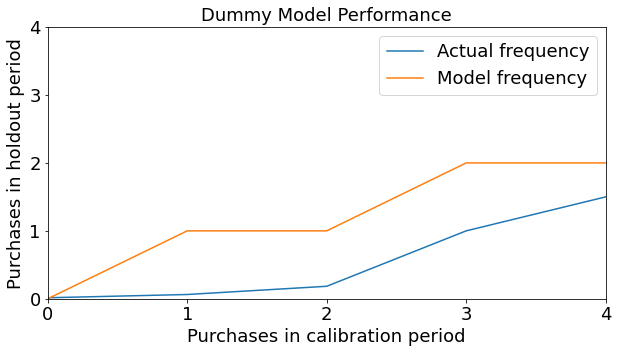

In [33]:
#Plot a visual to demonstrate dummy model performance
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(dummy_ch_df.groupby("frequency_cal").mean()["actual_purchases_holdout"],label=('frequency_holdout'))
ax.plot(dummy_ch_df.groupby("frequency_cal").mean()["dummy_pred_purchases_holdout"],label=('dummy_model_pred'))

ax.set_xticks([0,1,2,3,4])
ax.set_xlim(0,4)
ax.set_yticks([0,1,2,3,4])
ax.set_ylim(0,4)

plt.xlabel("Purchases in calibration period", fontsize=18)
plt.ylabel("Purchases in holdout period", fontsize=18)
plt.xlabel("Purchases in calibration period", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Dummy Model Performance",fontsize=18)
plt.legend(["Actual frequency","Model frequency"],fontsize=18)

#ax.legend()
#Save figure as png
plt.savefig("visuals/dummy_model_performance_repeat_purchasers.png");

###  1.0 BG/NBD model
Model features
- All customers including those with just 1 purchase

Model results
- Very strong RMSE, this is our best model
- We significantly improved upon our dummy model
- Our model doesn't suffer from the niave assumption that purchase rate will just continue
- Our predictions start to fail at higher frequencies but there are very few instances of these types of customers, a more balenced data set would aleviate this issue

Next steps
- Attempt on subsetted data of customers with more than 1 purchase

In [34]:
#Iniatialize bgf model
bgf_1 = BetaGeoFitter(penalizer_coef=0)

In [35]:
#Fit model to df_ch
bgf_1.fit(
        frequency = df_ch_1["frequency_cal"], 
        recency = df_ch_1["recency_cal"], 
        T = df_ch_1["T_cal"],   
        weights = None,  
        verbose = True)

Optimization terminated successfully.
         Current function value: 0.065817
         Iterations: 60
         Function evaluations: 63
         Gradient evaluations: 63


<lifetimes.BetaGeoFitter: fitted with 44463 subjects, a: 1.85, alpha: 55.22, b: 0.32, r: 0.02>

In [36]:
#Return rmse for first model
bgf_1_rmse = bgf_rmse(ch_1,bgf_1)
print(f'Model is accurate to within {round(bgf_1_rmse,ndigits=3)} purchases over {int(ch_1.eval_period)} days')

Model is accurate to within 0.142 purchases over 240 days


In [37]:
#There are so few examples of customers with more than 4 purchases in the calibaration period that we should limit our
#evaluation to 4 or fewer
df_ch_1.groupby("frequency_cal").count()

,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
frequency_cal,,,,,,
0.0,43702,43702,43702,43702,43702,43702
1.0,711,711,711,711,711,711
2.0,38,38,38,38,38,38
3.0,9,9,9,9,9,9
4.0,2,2,2,2,2,2
8.0,1,1,1,1,1,1


/Applications/anaconda3/envs/lifetime-env/lib/python3.10/site-packages/lifetimes/generate_data.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


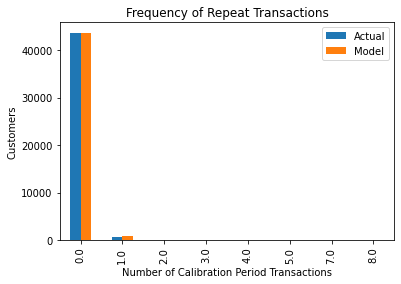

In [38]:
#Our model accurately esimates n purchases with in the calibation period
plot_period_transactions(bgf_1);

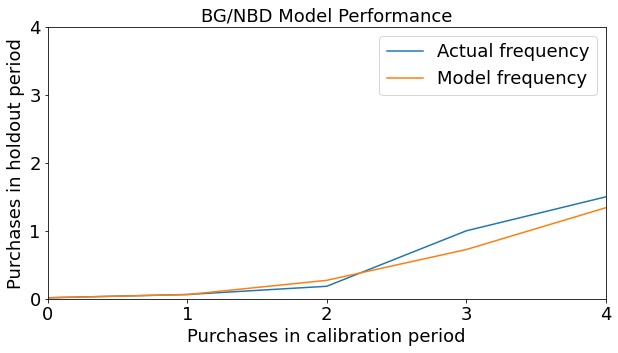

In [39]:
# testing: predicted vs actual purchases in holdout period
fig = plot_calibration_purchases_vs_holdout_purchases(bgf_1, df_ch_1,figsize=(10, 5))

plt.xlabel("Purchases in calibration period", fontsize=18)
plt.ylabel("Purchases in holdout period", fontsize=18)
plt.xlabel("Purchases in calibration period", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("BG/NBD Model Performance",fontsize=18)
plt.legend(["Actual frequency","Model frequency"],fontsize=18)

fig.set_xticks([0,1,2,3,4])
fig.set_xlim(0,4)
fig.set_yticks([0,1,2,3,4])
fig.set_ylim(0,4)
#Save figure as png
plt.savefig("visuals/final_bgf_model_performance.png");

###  2.0 BG/NBD model
Model features
- Subsetted data of customers with more than 1 purchase

Model results
- Still pretty strong RMSE but not as good as the full data set
- Our model is less accurate on this subset of repeat customers bc we can't inflate accuracy with the signficant n of correct 0 purchase perdictions that 
- That said, this model did much better than our dummy model did on repeat customers

Next steps
- Attempt regularization on the full data-set

In [40]:
#Iniatialze df_ch 
df_ch_2 = ch_2.df_ch_getdf()

In [41]:
#Iniatialize bgf model
bgf_2 = BetaGeoFitter(penalizer_coef=0.0)

In [42]:
#Fit model to df_ch
bgf_2.fit(
        frequency = df_ch_2["frequency_cal"],
        recency = df_ch_2["recency_cal"], 
        T = df_ch_2["T_cal"],   
        weights = None,  
        verbose = True)

Optimization terminated successfully.
         Current function value: 0.095057
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31


<lifetimes.BetaGeoFitter: fitted with 1384 subjects, a: 1.82, alpha: 135.02, b: 0.25, r: 1.13>

In [43]:
bgf_2_rmse = bgf_rmse(ch_2,bgf_2)
print(f'Model is accurate to within {round(bgf_2_rmse,ndigits=3)} purchases over {int(ch_2.eval_period)} days')

Model is accurate to within 0.505 purchases over 240 days


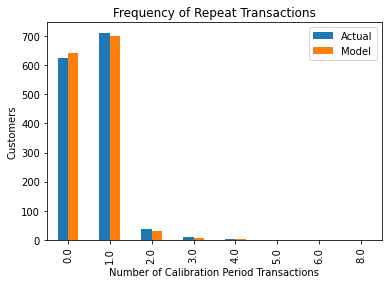

In [44]:
plot_period_transactions(bgf_2);

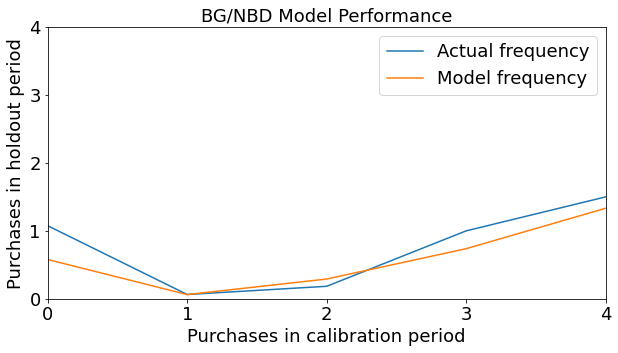

In [45]:
# testing: predicted vs actual purchases in holdout period 
fig = plot_calibration_purchases_vs_holdout_purchases(bgf_2, df_ch_2,figsize=(10, 5))

plt.xlabel("Purchases in calibration period", fontsize=18)
plt.ylabel("Purchases in holdout period", fontsize=18)
plt.xlabel("Purchases in calibration period", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("BG/NBD Model Performance",fontsize=18)
plt.legend(["Actual frequency","Model frequency"],fontsize=18)

fig.set_xticks([0,1,2,3,4])
fig.set_xlim(0,4)
fig.set_yticks([0,1,2,3,4])
fig.set_ylim(0,4);

###  3.0 BG/NBD model
Model features
- All customers including those with just 1 purchase
- Regularization in the form of l2 penalty

Model results
- Zero regularization produced the best result

Next steps
- Bring in a Gama Gama model to predict LTV using our best model `bgf_1` that has 0 regularization


In [46]:
#Documentation says that penalties in the order of 0.001 to 0.1 are effective
penalizer_coef_grid = {"bgf_3_0":0,"bgf_3_001":0.001,"bgf_3_05":0.05,"bgf_3_01":.01,"bgf_3_015":.015}
for penalizer in penalizer_coef_grid:
    model = BetaGeoFitter(penalizer_coef=penalizer_coef_grid[penalizer])
    model.fit(
        frequency = df_ch_1["frequency_cal"], 
        recency = df_ch_1["recency_cal"], 
        T = df_ch_1["T_cal"],   
        weights = None,  
        verbose = False)
    print(f'{penalizer} {bgf_rmse(ch_1,model)}')

bgf_3_0 0.1423220657607575
bgf_3_001 0.1469498734889828
bgf_3_05 0.1639692144239852
bgf_3_01 0.15561347485601168
bgf_3_015 0.15753830802505678


###  1.0 GG model
Model features
- Customers with monetary values in training and validation periods
- Minimal regularization

Model results
- Pretty good RMSE of less than $10


In [47]:
#Subset our data-set to ensure there are monetary values in both calibration and holdout periods
df_ch_2_subset = df_ch_2[df_ch_2["monetary_value_cal"]>0]
df_ch_2_subset = df_ch_2_subset[df_ch_2_subset["monetary_value_holdout"]>0]
df_ch_2_subset.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_unique_id,,,,,,,
041caba6a63ace5818387698ea85cdb2,1.0,247.0,297.0,51.73,1.0,71.78,240.0
083ca1aa470c280236380973a48f77c6,2.0,19.0,162.0,86.96,1.0,105.29,240.0
0b18593e033697810a62a987e77f4b8c,1.0,12.0,218.0,73.34,1.0,63.13,240.0
1b6c7548a2a1f9037c1fd3ddfed95f33,4.0,37.0,54.0,138.31,2.0,176.81,240.0
1da09dd64e235e7c2f29a4faff33535c,1.0,71.0,241.0,859.36,1.0,830.64,240.0


In [48]:
#Fitting our model using a minimal penalizer
gg_1 = GammaGammaFitter(penalizer_coef = 0.001)
gg_1.fit(frequency=df_ch_2_subset["frequency_cal"],monetary_value=df_ch_2_subset["monetary_value_cal"])

<lifetimes.GammaGammaFitter: fitted with 51 subjects, p: 10.43, q: 1.27, v: 9.91>

In [49]:
#returning and saving predicted average value for transactions
predicted_monetary_value = gg_1.conditional_expected_average_profit(frequency=df_ch_2_subset["frequency_holdout"],monetary_value=df_ch_2_subset["monetary_value_holdout"])
df_ch_2_subset['predicted_monetary_value'] = predicted_monetary_value
predicted_monetary_value.describe()

count     51.000000
mean     138.458452
std      136.872379
min       43.713787
25%       68.512605
50%      100.035614
75%      143.295964
max      819.621051
dtype: float64

In [50]:
#Return mean squared error for predicted and a dummy model that assumes purchase value to continue from calibration to holdout exactly the same.
gg_1_rmse = mean_squared_error(y_true=df_ch_2_subset["monetary_value_holdout"],y_pred=gg_1.conditional_expected_average_profit(frequency=df_ch_2_subset["frequency_holdout"],monetary_value=df_ch_2_subset["monetary_value_holdout"]),squared=False)
dummy_gg_rmse = mean_squared_error(y_true=df_ch_2_subset["monetary_value_holdout"],y_pred=df_ch_2_subset["monetary_value_cal"],squared=False)

In [51]:
print(f' dummy gg model RMSE w/ repeat cust only: {np.round(dummy_gg_rmse,2)}')
print(f' gg model RMSE w/ repeat cust only: {np.round(gg_1_rmse,2)}')

 dummy gg model RMSE w/ repeat cust only: 192.78
 gg model RMSE w/ repeat cust only: 6.63


### Predicting LTV For Return Customers
Given the large class imbalence, this prediction will focus only on return customers, those with more than 1 purchase.

In [52]:
#subset the summary data to just return customers, GG models do not accept a freq of zero
return_cust_summary = summary[summary["frequency"]>0]
#fit the GG model
final_gg = GammaGammaFitter(penalizer_coef = 0.001)
final_gg.fit(return_cust_summary['frequency'],
        return_cust_summary['monetary_value'])
#We can now estimate the average transaction value for all customers:
final_gg.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']).head()


customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    294.481754
0000b849f77a49e4a4ce2b2a4ca5be3f    294.481754
0000f46a3911fa3c0805444483337064    294.481754
0000f6ccb0745a6a4b88665a16c9f078    294.481754
0004aac84e0df4da2b147fca70cf8255    294.481754
dtype: float64

In [53]:
#Now we'll estimate LTV over the next 12 months
prediction_period = 12
# refit the bgf model to the full return customer data-set
bgf_1.fit(summary['frequency'], summary['recency'], summary['T'])

ltv_predictions = final_gg.customer_lifetime_value(
    bgf_1, #our best bgf model
    return_cust_summary['frequency'],
    return_cust_summary['recency'],
    return_cust_summary['T'],
    return_cust_summary['monetary_value'],
    time=prediction_period, # months
    discount_rate=0.0, # 
    freq ="D"
)
ltv_predictions

customer_unique_id
004288347e5e88a27ded2bb23747066c     3.196030
004b45ec5c64187465168251cd1c9c2f     2.683101
00a39521eb40f7012db50455bf083460     1.223831
011575986092c30523ecb71ff10cb473     3.019339
011b4adcd54683b480c4d841250a987f     5.062672
                                      ...    
fed519569d16e690df6f89cb99d4e682     3.769938
ff03923ad1eb9e32304deb7f9b2a45c9     4.958404
ff22e30958c13ffe219db7d711e8f564    14.277565
ff8892f7c26aa0446da53d01b18df463     1.882124
ff922bdd6bafcdf99cb90d7f39cea5b3     2.979693
Name: clv, Length: 2065, dtype: float64

In [54]:
print(f'total revenue from return customers in next 365 days {np.round(sum(ltv_predictions))}')

total revenue from return customers in next 365 days 14072.0


### Visuals

''

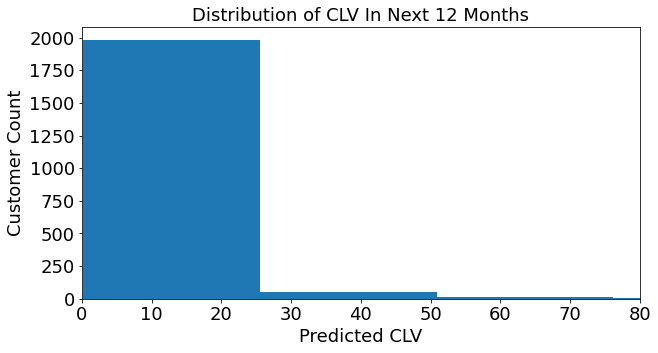

In [55]:
#Plot a histogram of our ltv predictions
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(ltv_predictions)
ax.set_xbound(0,80)
ax.set_title("Distribution of CLV In Next 12 Months",fontsize=18)
ax.set_ylabel("Customer Count",fontsize=18)
ax.set_xlabel("Predicted CLV",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("visuals/dist_of_clv_in_next_12months.png");
;

In [56]:
#Get a list of predicted CLV for n months in the future
prediction_period = 12
clv_sum_per_day = []
date_range = [*range(1, (prediction_period)+1, 1)]
for months in date_range:
    ltv_predictions = final_gg.customer_lifetime_value(
    bgf_1, #our best bgf model
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=months, # months
    discount_rate=0.0, # monthly discount rate ~ 12.7% annually
    freq ="D"
)
    clv_sum_per_day.append(sum(ltv_predictions))

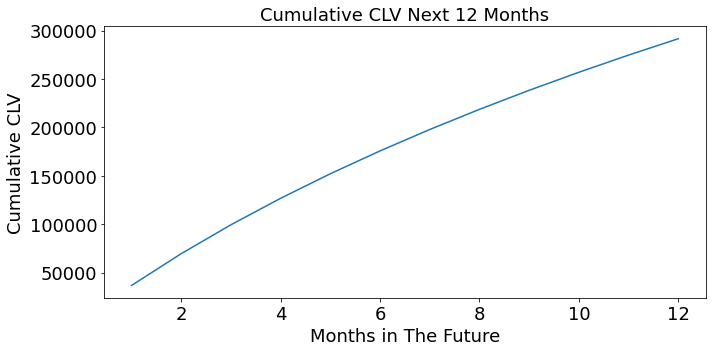

In [57]:
#Plot a line graph of cumulative CLV over the prediction period

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(date_range,clv_sum_per_day)
ax.set_title("Cumulative CLV Next 12 Months",fontsize=18)
ax.set_ylabel("Cumulative CLV",fontsize=18)
ax.set_xlabel("Months in The Future",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("visuals/cumulative_clv_future.png")
plt.tight_layout();

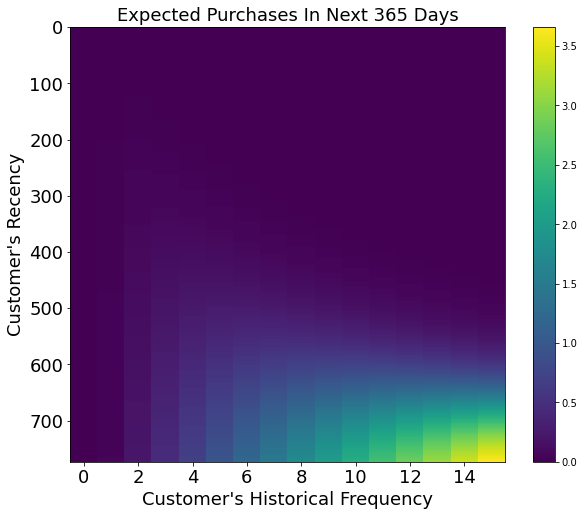

In [58]:
from lifetimes.plotting import plot_frequency_recency_matrix
fig, ax = plt.subplots(figsize=(10,8))
fig = plot_frequency_recency_matrix(bgf_1,T=365)
ax.set_title("Expected Purchases In Next 365 Days",fontsize=18)
fig.set_xlabel("Customer's Historical Frequency",fontsize=18)
fig.set_ylabel("Customer's Recency",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
plt.savefig("visuals/expected_purchases_matrix.png")

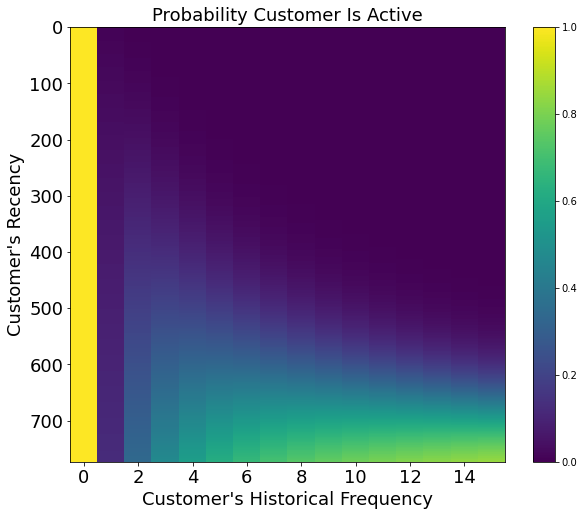

In [59]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(10,8))
fig = plot_probability_alive_matrix(bgf_1)
fig.set_title("Probability Customer Is Active",fontsize=18)
fig.set_xlabel("Customer's Historical Frequency",fontsize=18)
fig.set_ylabel("Customer's Recency",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
;
plt.savefig("visuals/probability_active_matrix.png")

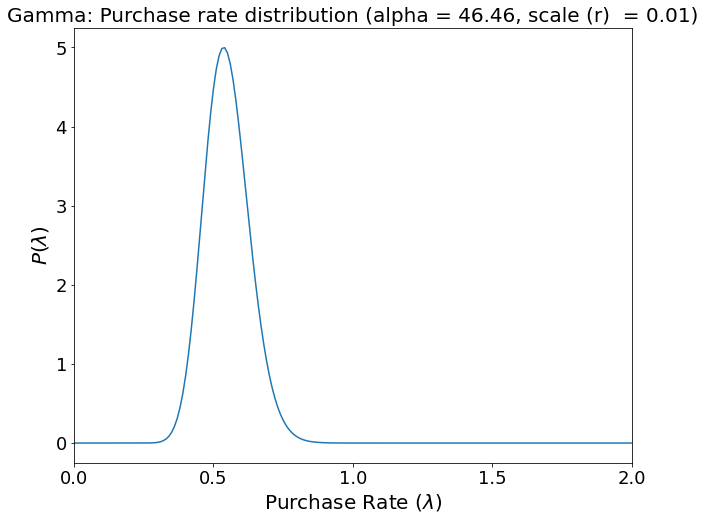

In [60]:
#Plot the heterogeneity of Purchase Rate using the parameters of our model
import scipy.stats as stats
fig, ax_gamma = plt.subplots(figsize = (10, 8))

x_gamma = np.linspace(0, 10, 1000)
y_gamma = stats.gamma.pdf(x_gamma, a=bgf_1.params_["alpha"], scale=bgf_1.params_["r"])
ax_gamma.plot(x_gamma, y_gamma, "-")
ax_gamma.set_title(f'Gamma: Purchase rate distribution (alpha = {bgf_1.params_["alpha"]:.2f}, scale (r)  = {bgf_1.params_["r"]:.2f})',fontsize=20)
ax_gamma.set_xlabel(r"Purchase Rate " '($\lambda$)',fontsize=20)
ax_gamma.set_ylabel(r'$P(\lambda)$',fontsize=20)
ax_gamma.set_xbound(0,2)
ax_gamma.set_xticks([0,.5,1,1.5,2]);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("visuals/gamma_purchase_rate_dist.png")


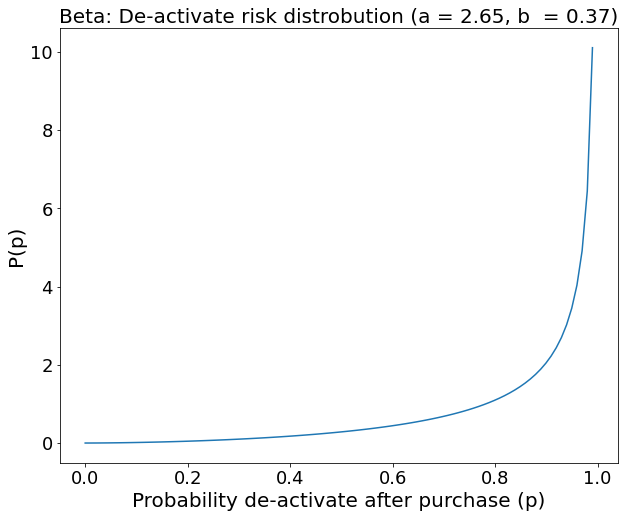

In [61]:
#Plot the heterogeneity of de-activate risk using the parameters of our model
#Our customers are not in a healthy position, much of them are highly likely to be de-activated already
fig, ax_beta = plt.subplots(figsize = (10, 8))
x_beta = np.linspace(0, 1, 100)
y_beta = stats.beta.pdf(x_beta, a=bgf_1.params_["a"], b=bgf_1.params_["b"])
ax_beta.plot(x_beta, y_beta, "-")
ax_beta.set_title(f'Beta: De-activate risk distrobution (a = {bgf_1.params_["a"]:.2f}, b  = {bgf_1.params_["b"]:.2f})',fontsize=20)
ax_beta.set_xlabel("Probability de-activate after purchase (p)" ,fontsize=20)
ax_beta.set_ylabel('P(p)',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("visuals/beta_deactivate_risk_dist.png")


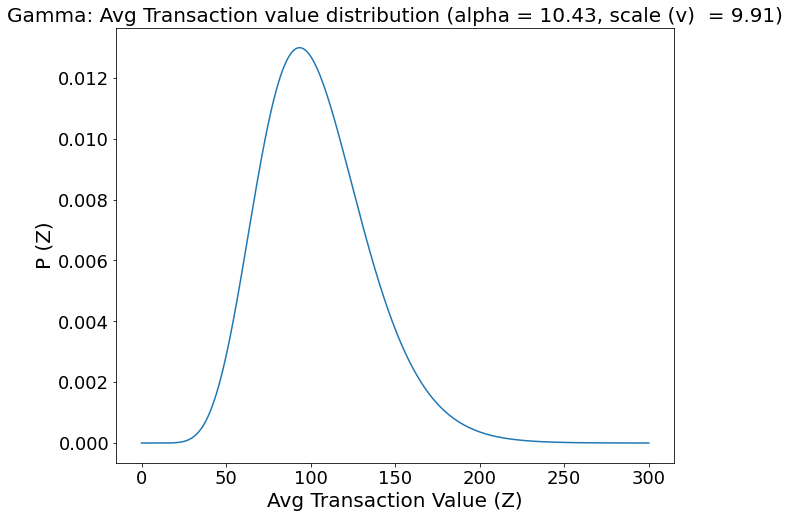

In [62]:
fig, ax_gamma = plt.subplots(figsize = (10, 8))

x_gamma = np.linspace(0, 300, 1000)
y_gamma = stats.gamma.pdf(x_gamma, a=gg_1.params_[0], scale=gg_1.params_[2])
ax_gamma.plot(x_gamma, y_gamma, "-")
ax_gamma.set_title(f'Gamma: Avg Transaction value distribution (alpha = {gg_1.params_[0]:.2f}, scale (v)  = {gg_1.params_[2]:.2f})',fontsize=20)
ax_gamma.set_xlabel(r"Avg Transaction Value " '(Z)',fontsize=20)
ax_gamma.set_ylabel(r'P (Z)',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
plt.savefig("visuals/avg_transaction_value_dist.png")


## Limitations & Next Steps
**Margin**

Most CLV formulas hold for product margin as part of the calculation. Multiplying margin by the other factors produces a customer lifetime *profit*. This project didn't have access to margin information thus it wasn't included.

Future iterations would include margin if that data became available.

**Limited business context applicability**

Applicability limited to non-contractual businesses with continuous purchases. There are other business contexts where this modeling approach is not applicable. [Breakdown of Olist business context](https://github.com/zander1268/custorama/blob/main/visuals/business_context.jpg?raw=true).

Future iterations of the model could be altered to better suit different business contexts.

**Limited number of repeat customers***

Because Gamma Gamma model fitters do not accept zero values in freq and monetary values, I had to fit and validate on the limited subset of users with a repeat purchases. Given the class imbalance this is a limited group. Ideally, there would be more data that included a greater number of repeat purchasers to help better validate gamma gamma model and demonstrate the performance of BG/NBD model over the dummy model.

## Conclusion

This project successfully created a user-friendly CLV prediction engine and validated it's performance on real world transactional data from Olist with minimal error. The app is built on the same data processing and modeling techniques as the validated model but is capable of taking in unstructured and unseen data from new merchants and returning important CLV predictions. The app will empower merchants to make better decisions and delight customers. It opens the door to a number of business analyses; marketing ROI, sales forecasts, company valuation, churn risk, and persona analysis. Olist can quickly roll out this tool to it's e-commerce merchants and enjoy greater commissions and retention rate.